# Preparando os dados
Nesse notebook vamos preparar os dados para análise.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
# importando dataset de treino
data = pd.read_csv("../data/titanic_train.csv")

In [5]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'class', 'age', 'sex', 'survived'], dtype='object')

In [6]:
data.head()

,Unnamed: 0,Unnamed: 0.1,class,age,sex,survived
0,191,192,1st class,adults,women,yes
1,103,104,1st class,adults,man,no
2,1280,1281,3rd class,child,man,no
3,60,61,1st class,adults,man,no
4,1034,1035,3rd class,adults,man,no


In [7]:
data['class'] = data['class'].astype("category")
data.age = data.age.astype("category")
data.sex = data.sex.astype("category")
data.survived = data.survived == 'yes'

In [8]:
x_cols = ['class', 'age', 'sex']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data[x_cols], data.survived, test_size=1/3., random_state=42)

## Tratando as colunas

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    #Helper function that converts values to Binary depending on input 
    def create_binary(self, obj, default):
        if obj == default:
            return 1
        else:
            return 0
    
    def change_class_to_number(self, obj):
        return int(obj[0])

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        # X.loc[:,'survived'] = X['survived'].apply( self.create_binary, args=("yes",) )
        
        X.loc[:,'age'] = X['age'].apply( self.create_binary, args=("adults",) )
        
        X.loc[:,'sex'] = X['sex'].apply( self.create_binary, args=("women",) )
        
        X.loc[:,'class'] = X['class'].apply( self.change_class_to_number)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)
            
# cs = ColumnSelector(columns=['class', 'age', 'sex'])
# cs.fit_transform(X_train).head()

In [11]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [12]:
ts = TypeSelector("category")
ts.fit_transform(X_train).head()

,class,age,sex
705,2nd class,adults,man
850,3rd class,adults,man
172,3rd class,child,man
125,3rd class,child,women
382,3rd class,adults,women


In [13]:
data.isna().sum()

Unnamed: 0      0
Unnamed: 0.1    0
class           0
age             0
sex             0
survived        0
dtype: int64

In [14]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            Imputer(strategy="median"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            Imputer(strategy="most_frequent"),
            OneHotEncoder()
        )),
        ("boolean_features", make_pipeline(
            TypeSelector("bool"),
            Imputer(strategy="most_frequent")
        ))
    ])
)

C:\Users\Esig\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Esig\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Esig\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
# preprocess_pipeline.fit(X_train)

# X_test_transformed = preprocess_pipeline.transform(X_test, y_test)
# X_test_transformed

In [17]:
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    SVC(kernel="rbf", random_state=42)
)

In [18]:
classifier_pipeline

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['class', 'age', 'sex'])), ('featureunion', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('typeselector', TypeSelector(dtype=<class 'numpy.numb...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))])

In [20]:
param_grid = {
    "svc__gamma": [0.1 * x for x in range(1, 6)]
}

classifier_model = GridSearchCV(classifier_pipeline, param_grid, cv=10)
# classifier_model.fit(X_train, y_train)

In [21]:
svc = SVC(kernel="rbf", random_state=42)

In [22]:
svc.fit(X_train, y_train)

C:\Users\Esig\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [24]:
# preprocess_pipeline.fit(X_test)

In [25]:
y_pred = svc.predict(X_test)

              precision    recall  f1-score   support

       False       0.77      0.99      0.86       201
        True       0.96      0.53      0.68       128

   micro avg       0.81      0.81      0.81       329
   macro avg       0.86      0.76      0.77       329
weighted avg       0.84      0.81      0.79       329

Accuracy geral: 0.8085106382978723


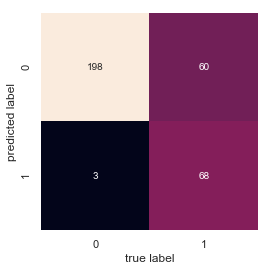

In [26]:
from sklearn.metrics import classification_report

#avaliacao
print(classification_report(y_test, y_pred))    
print("Accuracy geral:", accuracy_score(y_test, y_pred))

#Evaluating
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

# Dados para submissão

In [27]:
# importando dataset de teste
submission = pd.read_csv("../data/titanic_test.csv")

In [28]:
submission.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'class', 'age', 'sex'], dtype='object')

In [29]:
X_submission = submission[x_cols]

In [38]:
# preprocess_pipeline.fit(X_submission)

In [39]:
y_pred_submission = svc.predict(X_submission)

In [40]:
submission['survived'] = y_pred_submission

In [41]:
submission['survived'] = submission['survived'].apply(lambda x: 'yes' if x else 'no')

In [42]:
submission = submission[['Unnamed: 0', 'survived']]
submission.columns = ['id', 'survived']

In [43]:
submission.to_csv("../data/submission.csv", index=False)